# Experimentos com VKCM-K

In [15]:
import sys
from pathlib import Path

# Adiciona o caminho da pasta src ao sys.path
sys.path.append(str(Path("../src").resolve()))

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
import joblib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from vkcm import evaluate_varying_k, adjusted_rand_score, silhouette_score


In [17]:
# Carrega os dados balanceados e normalizados
X_train, y_train = joblib.load("../data/train_balanced.pkl")
X_val, y_val = joblib.load("../data/val_balanced.pkl")
X_test, y_test = joblib.load("../data/test_balanced.pkl")

# Junta tudo para clustering (sem separar)
X = np.concatenate([X_train, X_val, X_test], axis=0)
y = np.concatenate([y_train, y_val, y_test], axis=0)

print("Shape dos dados:", X.shape)
print("Distribuição das classes:", Counter(y))


Shape dos dados: (424, 44)
Distribuição das classes: Counter({np.int64(0): 212, np.int64(1): 212})


In [18]:
# Rodar experimento para K = 2, 3, 4, 5
best_k, best_result, all_results = evaluate_varying_k(X, y_true=y, k_values=[2, 3, 4, 5], runs=50, gamma=1.0)

print(f"Melhor K encontrado: {best_k}")
print(f"Silhouette médio: {best_result['avg_silhouette']:.4f}")
print(f"ARI com classes reais: {best_result['ari']:.4f}")


Melhor K encontrado: 2
Silhouette médio: 0.1770
ARI com classes reais: 0.2346


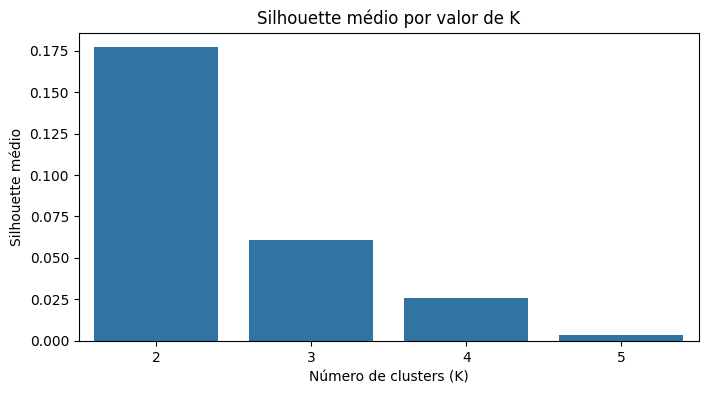

In [19]:
# Visualizar média de silhouette por K
avg_silhouettes = [all_results[k]['avg_silhouette'] for k in sorted(all_results.keys())]

plt.figure(figsize=(8, 4))
sns.barplot(x=sorted(all_results.keys()), y=avg_silhouettes)
plt.title('Silhouette médio por valor de K')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Silhouette médio')
plt.show()


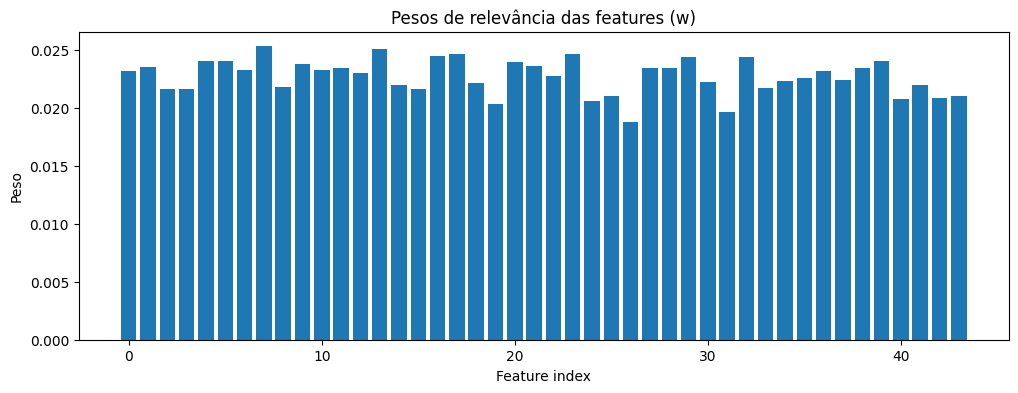

In [20]:
# Visualizar pesos de relevância da melhor execução
weights = best_result["relevance_weights"]
plt.figure(figsize=(12, 4))
plt.bar(range(len(weights)), weights)
plt.title("Pesos de relevância das features (w)")
plt.xlabel("Feature index")
plt.ylabel("Peso")
plt.show()


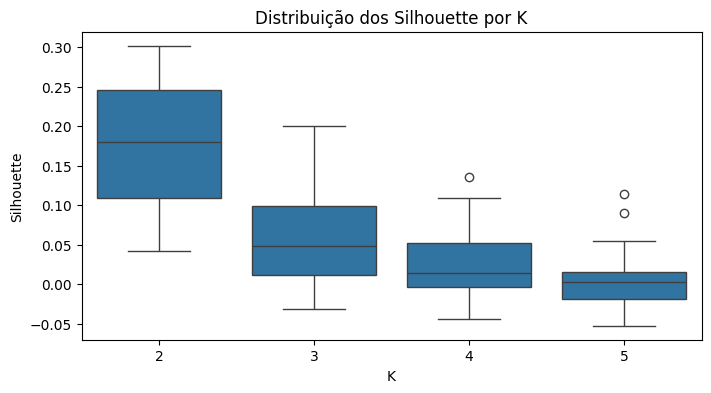

In [21]:
# Silhouette distribution between K
data = [(k, score) for k, res in all_results.items() for score in res['silhouette_scores']]
df_scores = pd.DataFrame(data, columns=["K", "Silhouette"])

plt.figure(figsize=(8, 4))
sns.boxplot(x="K", y="Silhouette", data=df_scores)
plt.title("Distribuição dos Silhouette por K")
plt.show()

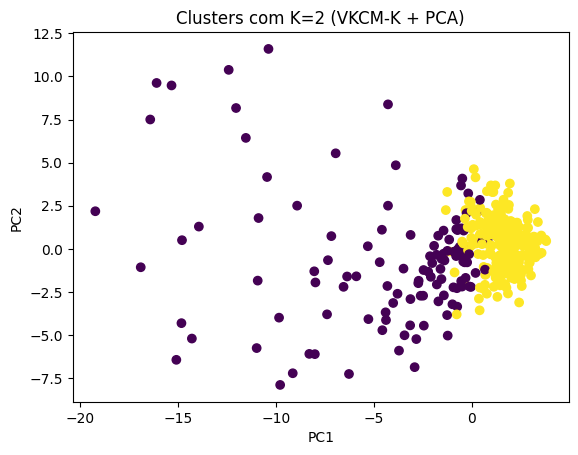

In [22]:
# plot dos pontos em 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_result["best_labels"], cmap='viridis')
plt.title(f"Clusters com K={best_k} (VKCM-K + PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [24]:
# comparação com Kmeans
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

print("KMeans ARI:", adjusted_rand_score(y, kmeans_labels))
print("KMeans Silhouette:", silhouette_score(X, kmeans_labels))

KMeans ARI: 0.031381542971484856
KMeans Silhouette: 0.5422939568517727
